In [ ]:
!pip install memory-profiler

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg
import pandas as pd
import memory_profiler as mp

# Helper functions

In [ ]:
def construct_laplacian_kernel_matrix(N, h):
    # Construct the matrix that defines the linear system

    rows = []
    cols = []
    values = []
    
    for i in range(N):
        for j in range(N):
            rows.append(N * i + j)
            cols.append(N * i + j)
            values.append(-4 / h ** 2)
            
            if i - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * (i - 1) + j)
                values.append(1 / h ** 2)

            if j - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * i + (j - 1))
                values.append(1 / h ** 2)

            if i + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * (i + 1) + j)
                values.append(1 / h ** 2)

            if j + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * i + (j + 1))
                values.append(1 / h ** 2)
    
    return rows, cols, values

# Dense solver

In [ ]:
def dense_solver(w):
    N = w.shape[0] - 2
    nx = N + 2
    ny = N + 2 # = nx

    h = 1 / (N + 1)
    
    # Construct the matrix that defines the linear system
    rows, cols, values = construct_laplacian_kernel_matrix(N, h)
    kernel_matrix = np.zeros((N ** 2, N ** 2), dtype=np.float32)
    kernel_matrix[rows, cols] = values
    
    start_mem = mp.memory_usage(max_usage=True)
    # Solve the linear system
    end_mem, psi = mp.memory_usage(proc=(scipy.linalg.solve, [
        kernel_matrix,
        -w[1:-1, 1:-1].flatten().reshape((N ** 2, 1)), # Cast vorticity to the required form
    ]), max_usage=True, retval=True)
    
    psi = psi.reshape(N, N)

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi, start_mem, end_mem


# Sparse solver

In [ ]:
def sparse_solver(w):
    N = w.shape[0] - 2
    nx = N + 2
    ny = N + 2 # = nx

    h = 1 / (N + 1)
    
    # Construct the sparse matrix
    rows, cols, values = construct_laplacian_kernel_matrix(N, h)

    # Create the sparse matrix from the above information
    kernel_matrix_sparse = scipy.sparse.csr_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))
    
    start_mem = mp.memory_usage(max_usage=True)
    # Solve the sparse linear system
    end_mem, psi = mp.memory_usage(proc=(scipy.sparse.linalg.spsolve, [
        kernel_matrix_sparse,
        -w[1:-1, 1:-1].flatten().reshape((N ** 2, 1)), # Cast vorticity to the required form
    ]), max_usage=True, retval=True)
    
    psi = psi.reshape(N, N)

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi, start_mem, end_mem


# Gauss-Seidel with SOR

In [ ]:
def sparse_gauss_seidel_with_sor_solver(w, r=None):
    N = w.shape[0] - 1
    nx = N + 1
    ny = N + 1 # = nx

    h = 1 / N

    # SOR parameter
    if r is None:
        r = 2 / (1 + np.pi / N) # optimal value

    psi = np.zeros((nx, ny), dtype=np.float32) # initialize the streamfunction

    start_mem = mp.memory_usage(max_usage=True)
    N_ITERATIONS = 4 * nx
    for iteration in range(1, N_ITERATIONS + 1):
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                psi[i, j] = (1 - r) * psi[i, j] + r * (
                    psi[i - 1, j] + psi[i + 1, j] + psi[i, j - 1] + psi[i, j + 1] + w[i, j] * h ** 2
                ) / 4

    end_mem = mp.memory_usage(max_usage=True)
                
    return psi, start_mem, end_mem

# Newton-Rhapson

In [ ]:
# Given the vorticity, solve the Poisson eqn. to find the streamfunction

def get_jacobian(N, h):
    # Construct the sparse matrix
    rows, cols, values = construct_laplacian_kernel_matrix(N, h)

    # Create the sparse matrix from the above information
    return scipy.sparse.csc_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))
    

def f(x, w, h):
    # this N is different from before
    N = int(np.sqrt(x.shape[0]))
    
    x = x.reshape(N, N)
    x = np.pad(x, (1, 1), mode="constant", constant_values=0)
    
    f = -4 * x[1:-1, 1:-1] + x[2:, 1:-1] + x[:-2, 1:-1] + x[1:-1, 2:] + x[1:-1, :-2]
    f = f / h ** 2 + w[1:-1, 1:-1]
    
    return f.reshape((-1, 1))


def newton_solver(w, TOL=1e-8, max_iter=100, quiet=True):
    N = w.shape[0] - 1
    nx = N + 1
    ny = N + 1 # = nx

    h = 1 / N
    
    # Initialization
    x_current = np.zeros(((N - 1) ** 2, 1))
    f_current = f(x_current, w, h)
    
    start_mem = mp.memory_usage(max_usage=True)
    count = 0
    while count < max_iter:
        count += 1
#         print(count)
        
        Jacobian = get_jacobian(N=N - 1, h=h)
        
        x_next = scipy.sparse.linalg.spsolve(Jacobian, Jacobian.dot(x_current) - f_current)
        x_next = x_next.reshape((-1, 1))
        
        f_current = f(x_next, w, h)
        
        f_norm = scipy.linalg.norm(f_current)
        x_norm = scipy.linalg.norm(x_next - x_current)
#         print(f_norm)
#         print(x_norm)
        if f_norm <= TOL or x_norm <= TOL:
            break
        
        x_current = x_next
#         print()
    
    end_mem = mp.memory_usage(max_usage=True)
    
    if not quiet:
        print(f"count={count}")
        
    psi = x_next.reshape(N - 1, N - 1)

    psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    return psi, start_mem, end_mem


In [ ]:
def newton_solver_n(w, n_iter, TOL=1e-8, quiet=True):
    N = w.shape[0] - 1
    nx = N + 1
    ny = N + 1 # = nx

    h = 1 / N
    
    # Initialization
    x_current = np.zeros(((N - 1) ** 2, 1))
    f_current = f(x_current, w, h)
    
    start_mem = mp.memory_usage(max_usage=True)
    count = 0
    while count < n_iter:
        count += 1
        
        Jacobian = get_jacobian(N=N - 1, h=h)
        
        x_next = scipy.sparse.linalg.spsolve(Jacobian, Jacobian.dot(x_current) - f_current)
        x_next = x_next.reshape((-1, 1))
        
        f_current = f(x_next, w, h)
        
        x_current = x_next
    
    end_mem = mp.memory_usage(max_usage=True)
    
    if not quiet:
        print(f"count={count}")
        
    psi = x_next.reshape(N - 1, N - 1)

    psi = np.pad(psi, (1, 1), mode="constant", constant_values=0)
    
    return psi, start_mem, end_mem

In [ ]:
# # Initialize grid and the value of the vorticity on it
# nx = ny = 21
# h = 1 / 20
# x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
# w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

# # Solve the system
# psi_1, _ = dense_solver(w)
# psi_2, _ = sparse_solver(w)
# psi_3, _, _ = sparse_gauss_seidel_with_sor_solver(w)
# psi_4, _, _ = newton_solver(w, quiet=False)

In [ ]:
# (
#     np.allclose(psi_1, psi_2), np.allclose(psi_1, psi_3), np.allclose(psi_1, psi_4),
#     np.allclose(psi_2, psi_3), np.allclose(psi_2, psi_4), np.allclose(psi_3, psi_4)
# )

In [ ]:
# for N in [10, 20, 40, 80, 120, 160, 240, 320, 400]:
#     print(N)
#     # Initialize grid and the value of the vorticity on it
#     nx = ny = N + 1
#     h = 1 / N
#     x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
#     w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

#     # Solve the system
#     psi_1, _ = sparse_solver(w)
#     psi_2, _, _ = newton_solver(w, quiet=False)
    
#     print(np.allclose(psi_1, psi_2))
#     print()

# Memory usage comparison

In [ ]:
# def df_from_performance_metrics(N_values, times, errors):
#     return pd.DataFrame({
#         "N": N_values,
#         "time": times,
#         "std": errors,
#     })

# df = df_from_performance_metrics(N_values, time_sparse, errors_sparse)
# df.to_csv("times_sparse.csv", index=False)

# df = df_from_performance_metrics(N_values, time_simple, errors_simple)
# df.to_csv("times_simple.csv", index=False)

# df = df_from_performance_metrics(N_values, time_gs, errors_gs)
# df.to_csv("times_gs.csv", index=False)

In [ ]:
# for solver in ["simple", "sparse", "gs"]:
#     df = pd.read_csv(f"times_{solver}.csv")
#     plt.errorbar(x=df["N"], y=df["time"], yerr=df["std"], label=solver)
    
# plt.legend()
# plt.xscale("log")

# Memory usage

Based on https://stackoverflow.com/questions/552744/how-do-i-profile-memory-usage-in-python/61472545#61472545

In [ ]:
# %%time

# N = 168
# nx = ny = N + 1
# h = 1 / N
# x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
# x_grid = x_grid.astype(np.float32)
# y_grid = y_grid.astype(np.float32)
# w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity
# w = w.astype(np.float32)

# _, start_mem, end_mem = newton_solver(w, quiet=False)
# # _, start_mem, end_mem = sparse_solver(w)
# print(start_mem)

# end_mem

count=1
112.61328125
CPU times: user 818 ms, sys: 2.83 s, total: 3.65 s
Wall time: 2.19 s


121.20703125

In [ ]:
# end_mem - start_mem

8.59375

In [ ]:
# with open("outputs/memory_manual_2/newton_manual_2.txt", "at") as file:
#     file.write(f"{N}, {start_mem}, {end_mem}\n")

In [ ]:
# %%time


# N_values = np.array([7, 14, 28, 56, 84, 112, 224, 336, 448, 672, 896])
# N_values = np.array([7, 14, 28, 56])
# N_values = np.array([336, 448])


# plt.figure(figsize=(10, 6))

# for n_iter in range(2, 4):
#     mems = []
    
#     for N in N_values:
#         print(N)

#         nx = ny = N + 1
#         h = 1 / N
#         x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
#         w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity
        
#         _, start_mem, end_mem = newton_solver_n(w, n_iter=n_iter, quiet=False)
#         mems.append(end_mem - start_mem)

#     plt.plot(N_values, mems, label=n_iter)    

# # plt.xscale("log")
# plt.legend()
# plt.show()

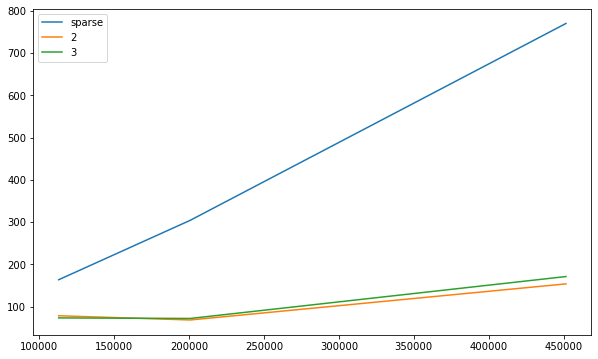

In [ ]:
sparse = [163.5234375, 304.1328125, 770.0625]
s2 = [78.26171875, 68.28515625, 153.71875]
s3 = [73.15234375, 71.86328125, 171.0625]

N_values = np.array([336, 448, 672]) ** 2

plt.figure(figsize=(10, 6))

plt.plot(N_values, sparse, label="sparse")
plt.plot(N_values, s2, label="2")
plt.plot(N_values, s3, label="3")

plt.legend()
plt.show()